In [ ]:
#%%

import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tf_keras import layers
from tf_keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np
from tf_keras.optimizers import Adam
from tf_keras.regularizers import l2

tf.keras.backend.clear_session()

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
  tf.config.experimental.set_memory_growth(gpu_devices[0], True)
  print('GPU found', gpu_devices[0])
else:
  print('No GPU found')

#define image size
IMG_SIZE = 224

#define batch size
BATCH_SIZE = 64

#training directory
TRAINING_DIR = "Train"
  
#training split
train_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = "training",
  validation_split = 0.25,
  seed = 225
)

#validation split, taken directly from the same directory as train
validation_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = 'validation',
  validation_split = 0.25,
  seed = 225
)

CLASS_NAMES = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

#data augmentation to increase robustness
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2) 
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training = True), y), num_parallel_calls = AUTOTUNE)

num_classes = len(CLASS_NAMES)

#normalizing the data
norm_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (norm_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (norm_layer(x), y))

#training model
model = Sequential([
  layers.Conv2D(64, (3, 3),  input_shape = (224, 224, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.2),  
  layers.Conv2D(128, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.2),
  layers.Conv2D(256, (5, 5)), 
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation = 'relu', kernel_regularizer = l2(0.02)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation = 'softmax')
])

model.compile(optimizer = Adam(learning_rate = 0.0001, weight_decay = 1e-6), 
              loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

#no of epochs
epochs = 50


#early stopping
early_stopping = tf_keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  mode = 'min', 
                                                  verbose = 1, 
                                                  patience = 10, 
                                                  restore_best_weights = True)

#class weights since the dataset is imbalanced
class_weights = {
    0: 0.677,  #bike
    1: 1.200,  #bus
    2: 1.425,  #hatchback
    3: 2.768,  #pickup
    4: 0.716,  #sedan
    5: 1.150,  #suv
    6: 0.792,  #truck
    7: 0.911   #tuktuk
}                                  

#fitting of the model
history = model.fit(train_ds, 
                    validation_data = validation_ds, 
                    epochs = epochs,
                    class_weight = class_weights,
                    callbacks = [early_stopping])

#accuracy and loss values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

true_labels = []
predicted_labels = []

for images, labels in val_ds:
  true_labels.extend(labels.numpy())
  pred = model.predict(images)
  predicted_labels.extend(np.argmax(pred, axis = 1))

confusion_matrix = confusion_matrix(true_labels, predicted_labels)

print('Confusion Matrix: ')
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot = True, fmt = 'd', xticklabels = CLASS_NAMES, yticklabels = CLASS_NAMES, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

score = model.evaluate(validation_ds, verbose = 0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names=CLASS_NAMES))

2025-01-20 14:06:58.173656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737374818.189499  392538 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737374818.194013  392538 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 14:06:58.210154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 5336 files belonging to 8 classes.
Using 4002 files for training.


I0000 00:00:1737374821.112234  392538 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4792 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 5336 files belonging to 8 classes.
Using 1334 files for validation.
Epoch 1/50


/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
E0000 00:00:1737374823.396997  392538 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-20 14:07:08.579736: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 786.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
W0000 00:00:1737374828.579768  392589 gpu_utils.cc:68] Failed to allocate memory for convolution redzone checkin

22/63 [=========>....................] - ETA: 23s - loss: 17.9955 - accuracy: 0.1477

KeyboardInterrupt: 

GPU found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 5336 files belonging to 8 classes.
Using 4002 files for training.
Found 5336 files belonging to 8 classes.
Using 1334 files for validation.
Epoch 1/50
 95/126 [=====================>........] - ETA: 7s - loss: 6.1040 - accuracy: 0.1681

2025-01-20 14:08:37.795669: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 46s 328ms/step - loss: 5.3366 - accuracy: 0.1802 - val_loss: 2.6551 - val_accuracy: 0.2466
Epoch 2/50
 95/126 [=====================>........] - ETA: 8s - loss: 2.3948 - accuracy: 0.2507

2025-01-20 14:09:22.891723: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 44s 333ms/step - loss: 2.3454 - accuracy: 0.2571 - val_loss: 2.0783 - val_accuracy: 0.3103
Epoch 3/50
 95/126 [=====================>........] - ETA: 8s - loss: 2.1086 - accuracy: 0.2829

2025-01-20 14:10:06.744044: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 44s 334ms/step - loss: 2.0913 - accuracy: 0.2934 - val_loss: 1.9355 - val_accuracy: 0.3321
Epoch 4/50
 95/126 [=====================>........] - ETA: 8s - loss: 2.0364 - accuracy: 0.3076

2025-01-20 14:10:50.385083: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 43s 329ms/step - loss: 2.0259 - accuracy: 0.3133 - val_loss: 1.9042 - val_accuracy: 0.3501
Epoch 5/50
 95/126 [=====================>........] - ETA: 8s - loss: 2.0086 - accuracy: 0.3161

2025-01-20 14:11:34.328846: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 44s 332ms/step - loss: 1.9967 - accuracy: 0.3198 - val_loss: 1.8511 - val_accuracy: 0.3898
Epoch 6/50
 95/126 [=====================>........] - ETA: 8s - loss: 1.9795 - accuracy: 0.3355

2025-01-20 14:12:18.590278: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 44s 336ms/step - loss: 1.9636 - accuracy: 0.3396 - val_loss: 1.8080 - val_accuracy: 0.3868
Epoch 7/50
 95/126 [=====================>........] - ETA: 8s - loss: 1.9451 - accuracy: 0.3467

2025-01-20 14:13:03.121743: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 44s 336ms/step - loss: 1.9379 - accuracy: 0.3466 - val_loss: 1.8173 - val_accuracy: 0.4085
Epoch 8/50
 95/126 [=====================>........] - ETA: 8s - loss: 1.9062 - accuracy: 0.3664

2025-01-20 14:13:46.941215: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 44s 332ms/step - loss: 1.9073 - accuracy: 0.3676 - val_loss: 1.7835 - val_accuracy: 0.4115
Epoch 9/50
 95/126 [=====================>........] - ETA: 8s - loss: 1.8864 - accuracy: 0.3868

2025-01-20 14:14:30.932555: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 44s 333ms/step - loss: 1.8886 - accuracy: 0.3883 - val_loss: 1.7957 - val_accuracy: 0.4303
Epoch 10/50
 95/126 [=====================>........] - ETA: 8s - loss: 1.8697 - accuracy: 0.3845

2025-01-20 14:15:15.122894: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 44s 334ms/step - loss: 1.8702 - accuracy: 0.3828 - val_loss: 1.7536 - val_accuracy: 0.4055
Epoch 11/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.8701 - accuracy: 0.3882

2025-01-20 14:15:58.079466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 43s 324ms/step - loss: 1.8719 - accuracy: 0.3881 - val_loss: 1.7513 - val_accuracy: 0.4160
Epoch 12/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.8296 - accuracy: 0.4039

2025-01-20 14:16:40.611546: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 42s 319ms/step - loss: 1.8312 - accuracy: 0.4058 - val_loss: 1.7605 - val_accuracy: 0.4085
Epoch 13/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.8184 - accuracy: 0.4095

2025-01-20 14:17:22.628506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 41s 312ms/step - loss: 1.8195 - accuracy: 0.4103 - val_loss: 1.7449 - val_accuracy: 0.4183
Epoch 14/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.8057 - accuracy: 0.4260

2025-01-20 14:18:02.658074: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 302ms/step - loss: 1.8071 - accuracy: 0.4220 - val_loss: 1.6821 - val_accuracy: 0.4580
Epoch 15/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7984 - accuracy: 0.4270

2025-01-20 14:18:42.943850: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 306ms/step - loss: 1.8023 - accuracy: 0.4265 - val_loss: 1.6646 - val_accuracy: 0.4625
Epoch 16/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7785 - accuracy: 0.4500

2025-01-20 14:19:23.567585: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 41s 309ms/step - loss: 1.7789 - accuracy: 0.4448 - val_loss: 1.7514 - val_accuracy: 0.4528
Epoch 17/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.8029 - accuracy: 0.4322

2025-01-20 14:20:04.167014: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 306ms/step - loss: 1.7944 - accuracy: 0.4345 - val_loss: 1.6398 - val_accuracy: 0.4610
Epoch 18/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7811 - accuracy: 0.4352

2025-01-20 14:20:44.617991: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 304ms/step - loss: 1.7813 - accuracy: 0.4325 - val_loss: 1.7513 - val_accuracy: 0.4423
Epoch 19/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7664 - accuracy: 0.4395

2025-01-20 14:21:24.170658: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 39s 298ms/step - loss: 1.7743 - accuracy: 0.4335 - val_loss: 1.6678 - val_accuracy: 0.4760
Epoch 20/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7644 - accuracy: 0.4474

2025-01-20 14:22:04.415697: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 306ms/step - loss: 1.7534 - accuracy: 0.4473 - val_loss: 1.6683 - val_accuracy: 0.4730
Epoch 21/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7750 - accuracy: 0.4434

2025-01-20 14:22:44.635481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 304ms/step - loss: 1.7673 - accuracy: 0.4445 - val_loss: 1.6482 - val_accuracy: 0.4745
Epoch 22/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7528 - accuracy: 0.4454

2025-01-20 14:23:24.170544: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 39s 295ms/step - loss: 1.7634 - accuracy: 0.4415 - val_loss: 1.6553 - val_accuracy: 0.4708
Epoch 23/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7504 - accuracy: 0.4586

2025-01-20 14:24:04.180812: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 307ms/step - loss: 1.7509 - accuracy: 0.4543 - val_loss: 1.6377 - val_accuracy: 0.4925
Epoch 24/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7310 - accuracy: 0.4678

2025-01-20 14:24:44.950030: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 41s 308ms/step - loss: 1.7383 - accuracy: 0.4638 - val_loss: 1.6620 - val_accuracy: 0.4910
Epoch 25/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7252 - accuracy: 0.4674

2025-01-20 14:25:25.301898: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 306ms/step - loss: 1.7331 - accuracy: 0.4650 - val_loss: 1.6536 - val_accuracy: 0.4970
Epoch 26/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7211 - accuracy: 0.4632

2025-01-20 14:26:06.005408: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 41s 309ms/step - loss: 1.7295 - accuracy: 0.4640 - val_loss: 1.6361 - val_accuracy: 0.4963
Epoch 27/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7401 - accuracy: 0.4622

2025-01-20 14:26:46.779388: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 305ms/step - loss: 1.7399 - accuracy: 0.4603 - val_loss: 1.6955 - val_accuracy: 0.4873
Epoch 28/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7155 - accuracy: 0.4793

2025-01-20 14:27:27.520805: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 41s 308ms/step - loss: 1.7088 - accuracy: 0.4823 - val_loss: 1.6639 - val_accuracy: 0.4760
Epoch 29/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7427 - accuracy: 0.4641

2025-01-20 14:28:07.291116: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 300ms/step - loss: 1.7366 - accuracy: 0.4623 - val_loss: 1.6429 - val_accuracy: 0.4903
Epoch 30/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7224 - accuracy: 0.4747

2025-01-20 14:28:47.724101: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 306ms/step - loss: 1.7240 - accuracy: 0.4748 - val_loss: 1.6125 - val_accuracy: 0.5097
Epoch 31/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7058 - accuracy: 0.4796

2025-01-20 14:29:27.921064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 305ms/step - loss: 1.7134 - accuracy: 0.4803 - val_loss: 1.6520 - val_accuracy: 0.4948
Epoch 32/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7072 - accuracy: 0.4928

2025-01-20 14:30:07.833177: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 40s 300ms/step - loss: 1.6980 - accuracy: 0.4898 - val_loss: 1.6514 - val_accuracy: 0.5120
Epoch 33/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7265 - accuracy: 0.4852

2025-01-20 14:30:46.919563: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 39s 294ms/step - loss: 1.7204 - accuracy: 0.4790 - val_loss: 1.6871 - val_accuracy: 0.4723
Epoch 34/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.8850 - accuracy: 0.4234

2025-01-20 14:31:25.583794: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 38s 289ms/step - loss: 1.8499 - accuracy: 0.4338 - val_loss: 1.6393 - val_accuracy: 0.4925
Epoch 35/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.7457 - accuracy: 0.4720

2025-01-20 14:32:04.187331: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 39s 293ms/step - loss: 1.7417 - accuracy: 0.4758 - val_loss: 1.6488 - val_accuracy: 0.4895
Epoch 36/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.6825 - accuracy: 0.4931

2025-01-20 14:32:43.248174: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 39s 294ms/step - loss: 1.6926 - accuracy: 0.4920 - val_loss: 1.6664 - val_accuracy: 0.4910
Epoch 37/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.6800 - accuracy: 0.5069

2025-01-20 14:33:22.005067: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 38s 290ms/step - loss: 1.6886 - accuracy: 0.5005 - val_loss: 1.6645 - val_accuracy: 0.5090
Epoch 38/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.6856 - accuracy: 0.4977

2025-01-20 14:34:00.244118: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 39s 293ms/step - loss: 1.6877 - accuracy: 0.4978 - val_loss: 1.6653 - val_accuracy: 0.5022
Epoch 39/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.6614 - accuracy: 0.5092

2025-01-20 14:34:38.487537: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 38s 285ms/step - loss: 1.6593 - accuracy: 0.5057 - val_loss: 1.6467 - val_accuracy: 0.4955
Epoch 40/50
 95/126 [=====================>........] - ETA: 7s - loss: 1.6750 - accuracy: 0.5026

2025-01-20 14:35:16.756704: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


126/126 [==============================] - 38s 291ms/step - loss: 1.6671 - accuracy: 0.5050 - val_loss: 1.6904 - val_accuracy: 0.5112
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 30.
1/1 [==============================] - 0s 54ms/step
Confusion Matrix: 


2025-01-20 14:35:41.412662: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation loss: 1.612548589706421
Validation accuracy: 0.5097451210021973


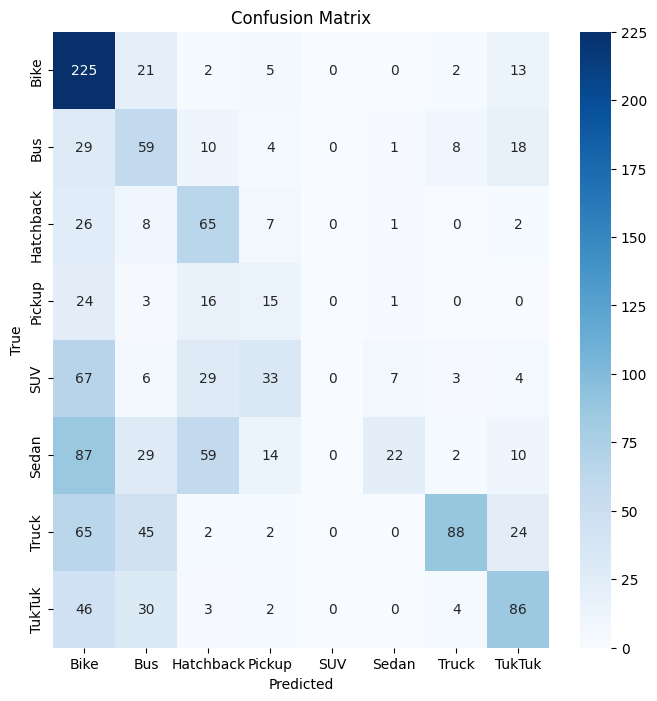

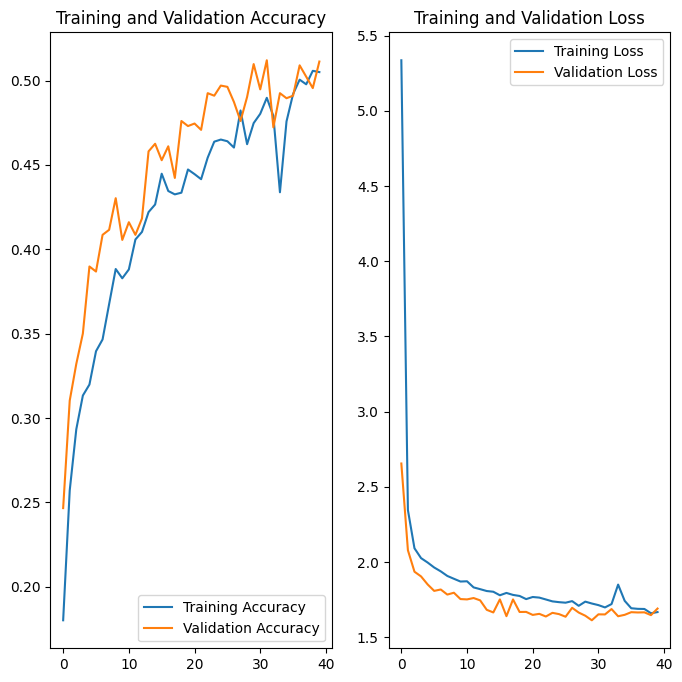

              precision    recall  f1-score   support

        Bike       0.40      0.84      0.54       268
         Bus       0.29      0.46      0.36       129
   Hatchback       0.35      0.60      0.44       109
      Pickup       0.18      0.25      0.21        59
         SUV       0.00      0.00      0.00       149
       Sedan       0.69      0.10      0.17       223
       Truck       0.82      0.39      0.53       226
      TukTuk       0.55      0.50      0.52       171

    accuracy                           0.42      1334
   macro avg       0.41      0.39      0.35      1334
weighted avg       0.47      0.42      0.37      1334



/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adiicmp/GitHub Repos/Python/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [ ]:
#%%

import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tf_keras import layers
from tf_keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np
from tf_keras.optimizers import Adam
from tf_keras.regularizers import l2

tf.keras.backend.clear_session()

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
  tf.config.experimental.set_memory_growth(gpu_devices[0], True)
  print('GPU found', gpu_devices[0])
else:
  print('No GPU found')

#define image size
IMG_SIZE = 224

#define batch size
BATCH_SIZE = 32

#training directory
TRAINING_DIR = "Train"
  
#training split
train_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = "training",
  validation_split = 0.25,
  seed = 225
)

#validation split, taken directly from the same directory as train
validation_ds = tf_keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels = "inferred",
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset = 'validation',
  validation_split = 0.25,
  seed = 225
)

CLASS_NAMES = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

#data augmentation to increase robustness
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2) 
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training = True), y), num_parallel_calls = AUTOTUNE)

num_classes = len(CLASS_NAMES)

#normalizing the data
norm_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (norm_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (norm_layer(x), y))

#training model
model = Sequential([
  layers.Conv2D(32, (3, 3),  input_shape = (224, 224, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3, 3)),
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(128, (5, 5)), 
  layers.Activation('relu'),
  layers.MaxPooling2D(2, 2),
  layers.Flatten(),
  layers.Dense(256, activation = 'relu', kernel_regularizer = l2(0.02)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation = 'softmax')
])

model.compile(optimizer = Adam(learning_rate = 0.0001, weight_decay = 1e-6), 
              loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

#no of epochs
epochs = 50


#early stopping
early_stopping = tf_keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  mode = 'min', 
                                                  verbose = 1, 
                                                  patience = 10, 
                                                  restore_best_weights = True)

#class weights since the dataset is imbalanced
class_weights = {
    0: 0.677,  #bike
    1: 1.200,  #bus
    2: 1.425,  #hatchback
    3: 2.768,  #pickup
    4: 0.716,  #sedan
    5: 1.150,  #suv
    6: 0.792,  #truck
    7: 0.911   #tuktuk
}                                  

#fitting of the model
history = model.fit(train_ds, 
                    validation_data = validation_ds, 
                    epochs = epochs,
                    class_weight = class_weights,
                    callbacks = [early_stopping])

#accuracy and loss values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

true_labels = []
predicted_labels = []

for images, labels in val_ds:
  true_labels.extend(labels.numpy())
  pred = model.predict(images)
  predicted_labels.extend(np.argmax(pred, axis = 1))

confusion_matrix = confusion_matrix(true_labels, predicted_labels)

print('Confusion Matrix: ')
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot = True, fmt = 'd', xticklabels = CLASS_NAMES, yticklabels = CLASS_NAMES, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

score = model.evaluate(validation_ds, verbose = 0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names=CLASS_NAMES))